In [4]:
import os
from itertools import product
from astropy.io import fits
from astropy.table import Table
import numpy as np
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt
import numpy.ma as ma
import yaml
from yaml.loader import SafeLoader


In [5]:
from cmaps_CLC import vel_map

In [6]:
from matplotlib import rcParams as rc
rc.update({'font.size': 20,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 20,\
           'ytick.labelsize' : 20,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [169]:
#
# Configure your entries here!
#
#CALDIR = '/home/sanchez/lvmdrp_scripts'
CALDIR = '/disk-a/sanchez/home/sda2/code/python/lvmcore/'
MDJ='/'
DATADIR = 'data/'
FILEID = '00004340'
file_sp1 = f'{DATADIR}/{MDJ}/lvm-object-sp1-{FILEID}.fits'
file_sp2 = f'{DATADIR}/{MDJ}/lvm-object-sp2-{FILEID}.fits'
file_sp3 = f'{DATADIR}/{MDJ}/lvm-object-sp3-{FILEID}.fits'
file_all =  f'{DATADIR}/{MDJ}/lvm-object-{FILEID}.fits'

In [273]:
#
# Reading the YAML file
#
#fibermap=f'{CALDIR}/LVM_SAIT_fibermap.yaml'
fibermap=f'{CALDIR}/metrology/lvm_fiducial_fibermap.yaml'
with open(fibermap) as f:
    data = yaml.load(f, Loader=SafeLoader)

#print(data['schema'][0])
colnames=[]
coltype=[]
for schema in data['schema']:
    colnames.append(schema['name'])
    coltype_now=schema['dtype']
    if (coltype_now=='finblock'):
        coltype_now='str'
    if (schema['name']=='finblock'):
        coltype_now='str'
    if (schema['name']=='ringnum'):
        coltype_now='float'
    #print(coltype_now)


    coltype.append(coltype_now)
    #    print(schema['name'],schema['dtype'])
    
#print(data['schema'][0])

print(len(data['fibers'])/3)

tab=Table(np.array(data['fibers']),names=colnames,dtype=coltype)
tab['targettype']

FileNotFoundError: [Errno 2] No such file or directory: '/home/sanchez/lvmdrp_scripts/metrology/lvm_fiducial_fibermap.yaml'

(-7.5449, 7.5449, -8.712, 8.712)

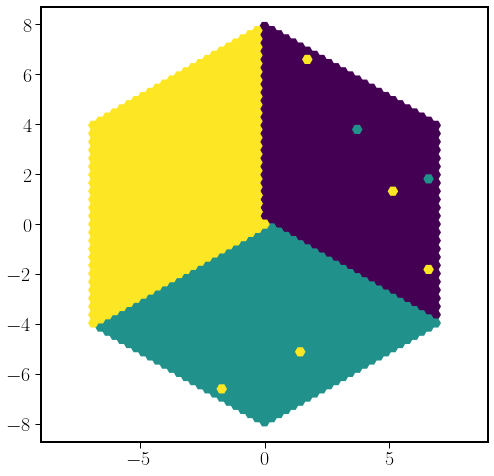

In [274]:
#
# Just a test plot
#
fig,ax = plt.subplots(1,1,figsize=(8,8))

# radius in data coordinates:
r = 0.25 # units
# radius in display coordinates:
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0] # points
# marker size as the area of a circle
marker_size = np.pi * r_**2

ax.scatter(tab['xpmm'],tab['ypmxx'],c=tab['spectrographid'],s=r_,marker='H',edgecolor='None')
ax.axis('equal')


In [275]:
tab1=tab[tab['spectrographid']==1]
tab2=tab[tab['spectrographid']==2]
tab3=tab[tab['spectrographid']==3]
mask_sp1 = (tab1['spectrographid']==1) & (tab1['fibstatus']==0) & (tab1['targettype']!='standard') 
mask_sp2 = (tab2['spectrographid']==2) & (tab2['fibstatus']==0) & (tab2['targettype']!='standard') 
mask_sp3 = (tab3['spectrographid']==3) & (tab3['fibstatus']==0) & (tab3['targettype']!='standard') 
print(len(tab1),len(tab2),len(tab3))

648 648 648


In [276]:
mask1 = (tab['spectrographid']==1) & (tab['fibstatus']==0) & (tab['targettype']!='standard') 
tab1=tab[mask1]
mask2 = (tab['spectrographid']==2) & (tab['fibstatus']==0) & (tab['targettype']!='standard')
tab2=tab[mask2]
mask3 = (tab['spectrographid']==3) & (tab['fibstatus']==0) & (tab['targettype']!='standard')
tab3=tab[mask3]

mask_all = (tab['fibstatus']==0) & (tab['targettype']=='science') 

print(len(tab1),len(tab2),len(tab3),len(tab[mask_all]))

638 638 635 1792


In [277]:
#
# Reading files
#
hdu_sp1=fits.open(file_sp1)
(ny_sp1,nx_sp1)=hdu_sp1[0].data.shape
hdr_sp1=hdu_sp1[0].header

hdu_sp2=fits.open(file_sp2)
(ny_sp2,nx_sp2)=hdu_sp2[0].data.shape
hdr_sp2=hdu_sp2[0].header

hdu_sp3=fits.open(file_sp3)
(ny_sp3,nx_sp3)=hdu_sp3[0].data.shape
hdr_sp3=hdu_sp3[0].header

data = np.zeros((ny_sp1+ny_sp2+ny_sp3,nx_sp1),dtype=float32)
inst = np.zeros((ny_sp1+ny_sp2+ny_sp3,nx_sp1),dtype=float32)
error = np.zeros((ny_sp1+ny_sp2+ny_sp3,nx_sp1),dtype=float32)
badpix = np.zeros((ny_sp1+ny_sp2+ny_sp3,nx_sp1),dtype=np.uint8)
ny1l=ny_sp1-1
ny2l=ny_sp1+ny_sp2
ny3l=ny_sp1+ny_sp2+ny_sp3
ny30=ny_sp1+ny_sp2
data[0:ny_sp1,:]=hdu_sp1[0].data
data[ny_sp1:ny2l,:]=hdu_sp3[0].data
data[ny30:ny3l,:]=hdu_sp2[0].data

inst[0:ny_sp1,:]=hdu_sp1[1].data
inst[ny_sp1:ny2l,:]=hdu_sp3[1].data
inst[ny30:ny3l,:]=hdu_sp2[1].data

error[0:ny_sp1,:]=hdu_sp1[2].data
error[ny_sp1:ny2l,:]=hdu_sp3[2].data
error[ny30:ny3l,:]=hdu_sp2[2].data        

badpix[0:ny_sp1,:]=hdu_sp1[3].data
badpix[ny_sp1:ny2l,:]=hdu_sp3[3].data
badpix[ny30:ny3l,:]=hdu_sp2[3].data

W=WCS(hdu_sp1[0].header)
W.wcs.crval=W.wcs.crval*10000000000
W.wcs.cdelt=W.wcs.cdelt*10000000000

primhdu = fits.PrimaryHDU(data=data,header=W.to_header())
hdulist=fits.HDUList([primhdu])
hdulist.append(fits.ImageHDU(data=error,name='ERROR'))
hdulist.append(fits.ImageHDU(data=badpix,name='BADPIX'))
hdulist.append(fits.ImageHDU(data=inst,name='INSTFWHM'))
hdulist.writeto(file_all,overwrite=True)
        





In [278]:
wcs_sp1 = WCS(hdr_sp1)
wcs_sp2 = WCS(hdr_sp2)
wcs_sp3 = WCS(hdr_sp3)


wl = W.wcs.crval[0]+W.wcs.cdelt[0]*(np.arange(nx_sp1)-1)


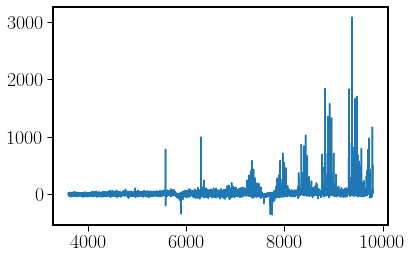

In [279]:
plt.plot(wl,hdu_sp3[0].data[347,:])
i_ha = int((6563/10000000000-wcs_sp1.wcs.crval[0])/wcs_sp1.wcs.cdelt[0])
w_ha = 50
#plt.xlim(6400,6800)
#print(wl)
#print(wcs_sp1)

In [280]:
ha_sp1_s = hdu_sp1[0].data[:,i_ha-w_ha:i_ha+w_ha].sum(axis=1)
ha_sp2_s = hdu_sp2[0].data[:,i_ha-w_ha:i_ha+w_ha].sum(axis=1)
ha_sp3_s = hdu_sp3[0].data[:,i_ha-w_ha:i_ha+w_ha].sum(axis=1)
ha_s = hdulist[0].data[:,i_ha-w_ha:i_ha+w_ha].sum(axis=1)
print(ha_s.shape)
#print(ha_sp3_s)

(1944,)


nan nan nan


<ipython-input-281-75ecf45929b1>:8: RuntimeWarning: divide by zero encountered in log10
  c=np.log10(ha_s[mask_all])
<ipython-input-281-75ecf45929b1>:8: RuntimeWarning: invalid value encountered in log10
  c=np.log10(ha_s[mask_all])


(-7.6, 7.6)

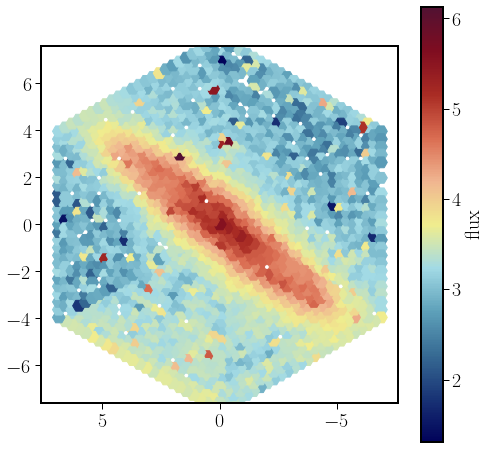

In [281]:
color_cm_now = vel_map()

fig,ax = plt.subplots(1,1,figsize=(8,8))
r = 0.35 # units
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0] # points
marker_size = np.pi * r_**2

c=np.log10(ha_s[mask_all])
tab_now=tab[mask_all]
x=(-1)*tab_now['xpmm']#[0:nmax]
y=tab_now['ypmxx']#[0:nmax]
sc=ax.scatter(x,y,c=c,s=r_,marker='H',edgecolor=None,cmap=color_cm_now)#,vmin=0,vmax=5)#,norm=norm)
ax.axis('square')
cbar = fig.colorbar(sc,label=r'flux');
print(np.median(c),np.mean(c),np.std(c))
ax.set_xlim(7.6,-7.6)
ax.set_ylim(-7.6,7.6)



nan nan nan
nan nan nan


<ipython-input-288-da88a66d4477>:11: RuntimeWarning: divide by zero encountered in log10
  c1=np.log10(ha_sp1_s[mask_sp1])
<ipython-input-288-da88a66d4477>:11: RuntimeWarning: invalid value encountered in log10
  c1=np.log10(ha_sp1_s[mask_sp1])
<ipython-input-288-da88a66d4477>:18: RuntimeWarning: divide by zero encountered in log10
  c2=np.log10(ha_sp2_s[mask_sp2])
<ipython-input-288-da88a66d4477>:18: RuntimeWarning: invalid value encountered in log10
  c2=np.log10(ha_sp2_s[mask_sp2])
<ipython-input-288-da88a66d4477>:26: RuntimeWarning: divide by zero encountered in log10
  c3=np.log10(ha_sp3_s[mask_sp3])
<ipython-input-288-da88a66d4477>:26: RuntimeWarning: invalid value encountered in log10
  c3=np.log10(ha_sp3_s[mask_sp3])


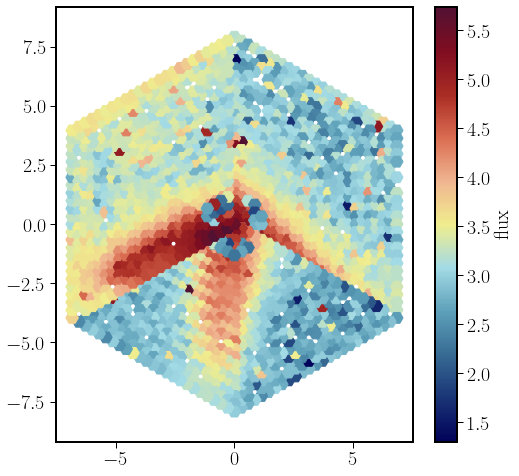

In [288]:
color_cm_now = vel_map()

#mask = (tab_s['fibstatus']==0) & (tab_s['targettype']!='standard')
#tab_now = tab_s[mask]

fig,ax = plt.subplots(1,1,figsize=(8,8))
r = 0.35 # units
r_ = ax.transData.transform([r,0])[0] - ax.transData.transform([0,0])[0] # points
marker_size = np.pi * r_**2

c1=np.log10(ha_sp1_s[mask_sp1])
tab_now=tab1
x1=tab_now['xpmm']#[0:nmax]
y1=tab_now['ypmxx']#[0:nmax]
sc1=ax.scatter(x1,y1,c=c1,s=r_,marker='H',edgecolor=None,cmap=color_cm_now)#,vmin=0,vmax=5)#,norm=norm)
ax.axis('equal')

c2=np.log10(ha_sp2_s[mask_sp2])
tab_now=tab2
x2=tab_now['xpmm']#[0:nmax]
y2=tab_now['ypmxx']#[0:nmax]
sc2=ax.scatter(x2,y2,c=c2,s=r_,marker='H',edgecolor=None,cmap=color_cm_now)#,vmin=0,vmax=5)#,norm=norm)
ax.axis('equal')

#c3=np.log10(np.flip(ha_sp3_s)[mask_sp3])
c3=np.log10(ha_sp3_s[mask_sp3])
tab_now=tab3
x3=tab_now['xpmm']#[0:nmax]
y3=tab_now['ypmxx']#[0:nmax]
sc3=ax.scatter(x3,y3,c=c3,s=r_,marker='H',edgecolor=None,cmap=color_cm_now)#,vmin=0,vmax=5)#,norm=norm)
ax.axis('equal')




cbar = fig.colorbar(sc1,label=r'flux');
print(np.median(c1),np.mean(c1),np.std(c1))
print(np.median(c2),np.mean(c2),np.std(c2))